## Import Library
___

In [1]:
import os
import random

import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from colorama import Fore

from PIL import Image
import cv2

import warnings
warnings.filterwarnings('ignore')

## Road and Read Gastroscopy Data
___

In [2]:
meta_data = pd.read_csv('/kaggle/input/metadataset/raw_annotation1.csv')

## Drop Colonoscopy, Just Choose Gastroscopy(위 내시경)
meta_data = meta_data[meta_data['organ'] == '위'].reset_index(drop=True)
print('Shape of DataFrame: ', meta_data.shape)
meta_data.head(5)

Shape of DataFrame:  (2915, 13)


,image_path,image_height,image_width,organ,lesion,location,shape_type_polygon,polygon_mask,bounding_box_shape,box_xmin,box_ymin,box_xmax,box_ymax
0,1_1_00011.png,2048,2048,위,궤양,1,polygon,"1257.45,738.30;1212.77,748.94;1168.09,748.94;1...",rectangle,763.829787,365.957447,1304.255319,748.936170
1,1_1_00011.png,2048,2048,위,궤양,1,polygon,"1421.28,955.32;1387.23,985.11;1368.09,1025.53;...",rectangle,1148.936170,897.872340,1421.276596,1082.978723
2,1_1_00014.png,2048,2048,위,궤양,1,polygon,"1065.96,1110.64;1040.43,1148.94;1010.64,1182.9...",rectangle,521.276596,561.702128,1078.723404,1225.531915
3,1_1_00017.png,2048,2048,위,궤양,1,polygon,"1246.30,514.89;1197.36,508.51;1154.81,502.13;1...",rectangle,884.595745,502.127660,1376.085106,753.191489
4,1_1_00018.png,2048,2048,위,궤양,1,polygon,"1397.36,389.36;1352.68,382.98;1314.38,404.26;1...",rectangle,1161.191489,382.978723,1654.808511,1074.468085


In [3]:
meta_data['image_id'] = meta_data['image_path'].copy()

map_path = {os.path.basename(x): x for x in glob('../input/gastroscopy-256x256-resized-png/*/*.png')}
meta_data['image_path'] = meta_data['image_id'].map(map_path)

**Rename columns & values**

- **대장**: `colonoscopy`
 
- **위**: `gastroscopy`

- **궤양**: `ulcer`, `label: 1`

- **용종**: `polyp`, `label: 2`

- **암**: `cancer`, `label: 3`

In [4]:
organ_dict = dict(
    대장 = 'colonoscopy',
    위 = 'gastroscopy'
) 

lesion_dict = dict(
    암 = 'cancer',
    궤양 = 'ulcer',
    용종 = 'polyp'
)

In [5]:
meta_data = meta_data.rename(columns={'image_height':'height','image_width':'width',
                                     'box_xmax': 'x_max', 'box_xmin':'x_min',
                                     'box_ymax': 'y_max', 'box_ymin':'y_min'})

## organ: 위, 대장
meta_data['organ'] = meta_data['organ'].map(organ_dict)

## lesion: 암, 궤양, 용종
meta_data['lesion'] = meta_data['lesion'].map(lesion_dict)

meta_data['lesion_label'] = meta_data['lesion'].map({'ulcer': 1, 'polyp': 2, 'cancer': 3})

In [6]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image_path          2915 non-null   object 
 1   height              2915 non-null   int64  
 2   width               2915 non-null   int64  
 3   organ               2915 non-null   object 
 4   lesion              2915 non-null   object 
 5   location            2915 non-null   int64  
 6   shape_type_polygon  2915 non-null   object 
 7   polygon_mask        2915 non-null   object 
 8   bounding_box_shape  2915 non-null   object 
 9   x_min               2915 non-null   float64
 10  y_min               2915 non-null   float64
 11  x_max               2915 non-null   float64
 12  y_max               2915 non-null   float64
 13  image_id            2915 non-null   object 
 14  lesion_label        2915 non-null   int64  
dtypes: float64(4), int64(4), object(7)
memory usage: 341.7+

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">
    
=> I checked if there were two different lesion types in each image, but there were no cases with two different lesion types.

=> This means that **if an image has a cancer type, it only contains one or more cancer boxes.**

In [7]:
print(f'{Fore.GREEN}=> There are no image which has two different lesion types')

tmp = meta_data.groupby(['image_id'])['lesion'].agg(lambda x: x.nunique()).reset_index()
tmp['lesion'].value_counts()

=> There are no image which has two different lesion types


lesion
1    1997
Name: count, dtype: int64

## EDA
___

In [8]:
!pip -q install palettable
import palettable.colorbrewer.qualitative as pbq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 10.8 MB/s eta 0:00:00


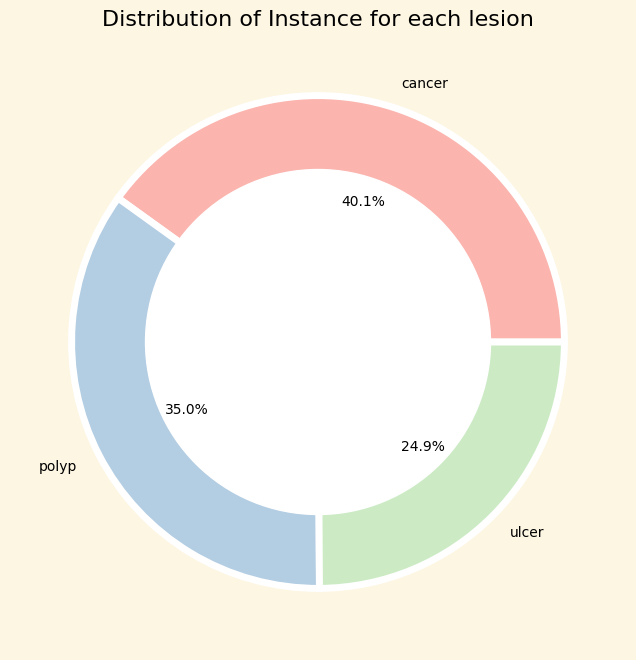

In [9]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(12,8))

tmp = meta_data['lesion'].value_counts()
plt.title('Distribution of Instance for each lesion')
plt.pie(tmp, labels=tmp.index, autopct='%.1f%%', colors=pbq.Pastel1_7.hex_colors, wedgeprops={'linewidth': 5, 'edgecolor':'white'})
my_circle = plt.Circle((0,0),0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

In [10]:
tmp = meta_data.copy()

tmp['h_ratio'] = 256 / tmp['height']
tmp['w_ratio'] = 256 / tmp['width']

tmp['x_min'] = tmp['x_min'] * tmp['w_ratio']
tmp['y_min'] = tmp['y_min'] * tmp['h_ratio']
tmp['x_max'] = tmp['x_max'] * tmp['w_ratio']
tmp['y_max'] = tmp['y_max'] * tmp['h_ratio']

tmp['w'] = tmp['x_max'] - tmp['x_min']
tmp['h'] = tmp['y_max'] - tmp['y_min']
tmp['x_mid'] = (tmp['x_max'] + tmp['x_min']) / 2
tmp['y_mid'] = (tmp['y_max'] + tmp['y_min']) / 2

tmp['aspect_ratio'] = tmp['w'] / tmp['h']
tmp['area'] = tmp['w'] * tmp['h'] / (256*256) * 100

#### X_mid, Y_min Coordinates for `Ulcer, Cancer, Polyp`

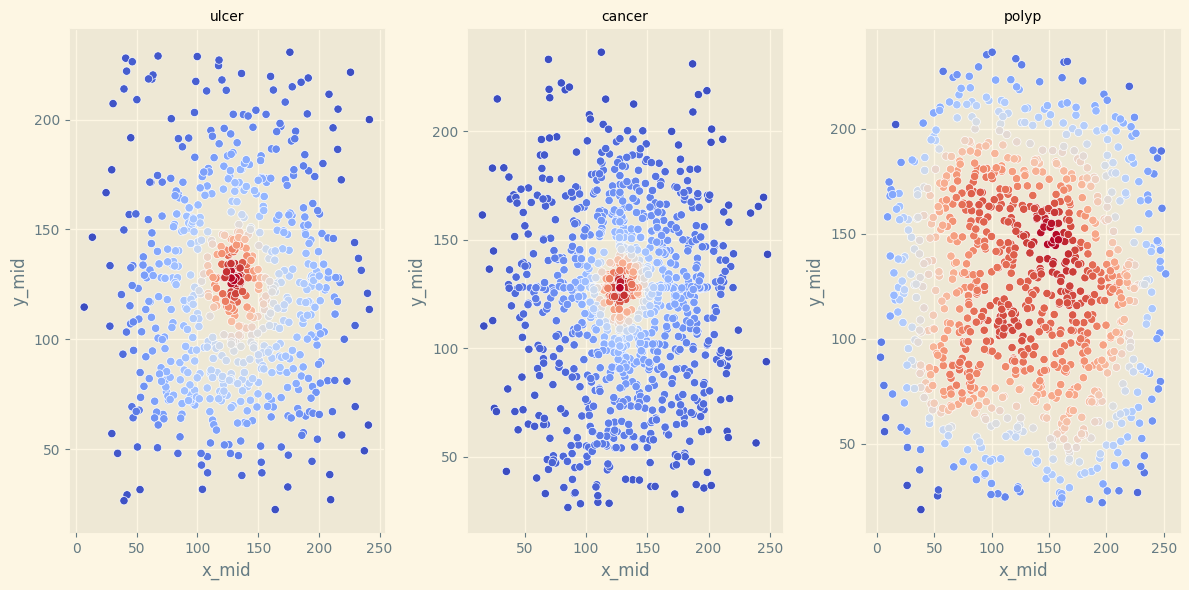

In [11]:
plt.figure(figsize=(12,6))
from scipy.stats import gaussian_kde

for i, label in enumerate(tmp['lesion'].unique()):
    plt.subplot(1,3,i+1)
    tmp2 = tmp[tmp['lesion'] == label]
    plt.title(label, size=10)
    xy = np.vstack([tmp2['x_mid'], tmp2['y_mid']])
    z = gaussian_kde(xy)(xy)
    sns.scatterplot(x=tmp2['x_mid'], y=tmp2['y_mid'], c=z, cmap='coolwarm')

plt.tight_layout()
plt.show()

#### Bbox Metadata

In [12]:
print(f'{Fore.GREEN}There is a total of {tmp.image_id.nunique()} Image which have bbox annotation')
print(f'{Fore.GREEN}There is a total of {len(tmp)} bboxes')
print(f'{Fore.GREEN}On Average, There is {len(tmp)//tmp.image_id.nunique()} bboxes per images')
print(f'{Fore.GREEN}The image with the most bboxes conatins {tmp.groupby(["image_id"]).size().max()}')
print(f'{Fore.GREEN}The image with the least bboxes contatins {tmp.groupby(["image_id"]).size().min()}')
print(f'{Fore.GREEN}The average of bbox area is {int(np.mean(tmp["area"]))}')
print(f'{Fore.GREEN}The max of bbox area is {int(np.max(tmp["area"]))}')
print(f'{Fore.GREEN}The min of bbox area is {int(np.min(tmp["area"]))}')

There is a total of 1997 Image which have bbox annotation
There is a total of 2915 bboxes
On Average, There is 1 bboxes per images
The image with the most bboxes conatins 29
The image with the least bboxes contatins 1
The average of bbox area is 21
The max of bbox area is 88
The min of bbox area is 0


#### Bbox Aspect_ratio

=> The mean of aspect ratio for ulcer: 1.1313969186888475
=> The mean of aspect ratio for cancer: 1.161027902111734
=> The mean of aspect ratio for polyp: 1.0525374083076138


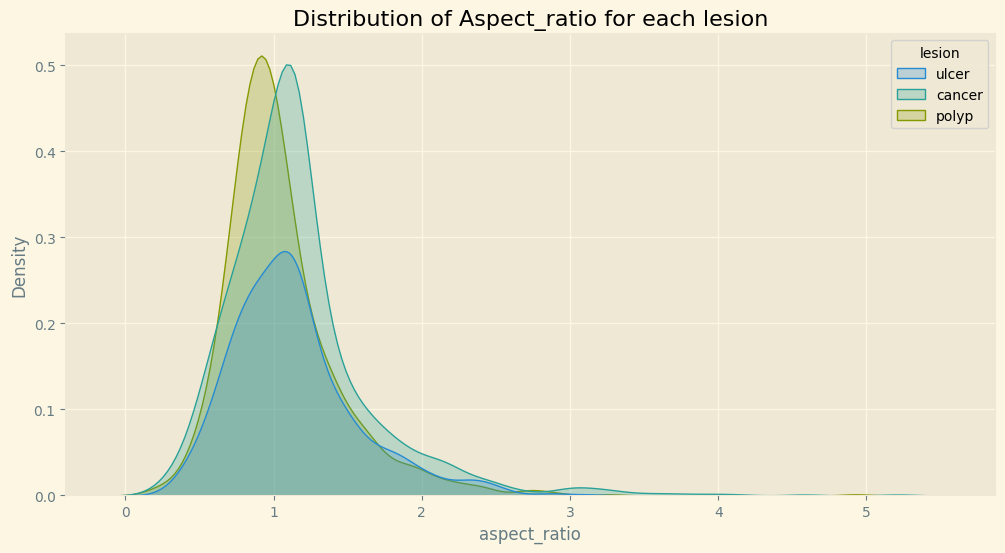

In [13]:
plt.figure(figsize=(12,6))

print(f'{Fore.BLUE}=> The mean of aspect ratio for ulcer: {tmp[tmp["lesion"] == "ulcer"]["aspect_ratio"].mean()}')
print(f'{Fore.BLUE}=> The mean of aspect ratio for cancer: {tmp[tmp["lesion"] == "cancer"]["aspect_ratio"].mean()}')
print(f'{Fore.BLUE}=> The mean of aspect ratio for polyp: {tmp[tmp["lesion"] == "polyp"]["aspect_ratio"].mean()}')

plt.title('Distribution of Aspect_ratio for each lesion')
sns.kdeplot(data=tmp, x='aspect_ratio', shade=True, hue='lesion')
plt.show()

#### Bbox Area

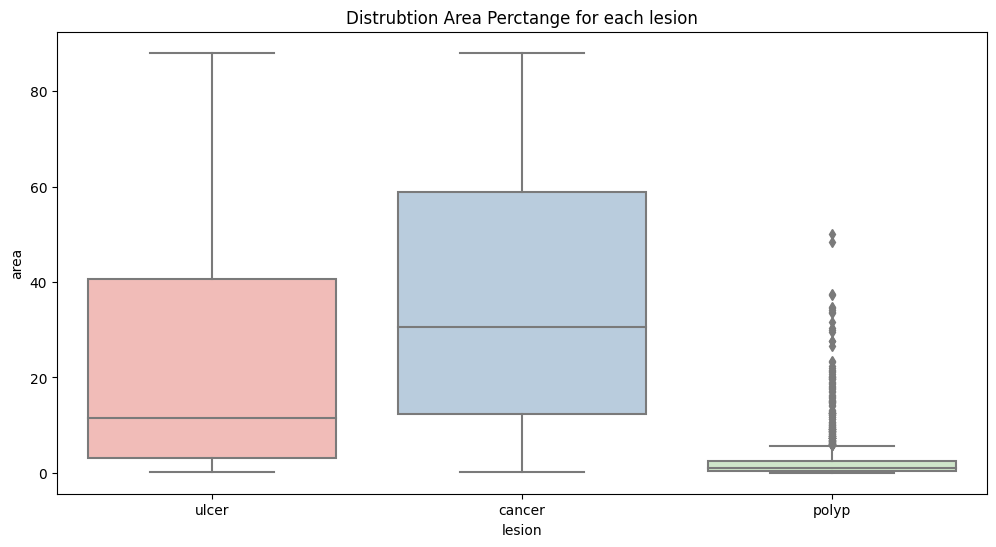

In [14]:
plt.style.use('default')
plt.figure(figsize=(12,6))

plt.title('Distrubtion Area Perctange for each lesion')
sns.boxplot(x=tmp['lesion'], y=tmp['area'], palette=pbq.Pastel1_7.hex_colors)

plt.show()

#### t-SNE Visualization

In [15]:
features = ['x_mid', 'y_mid', 'w', 'h', 'area', 'aspect_ratio']
X = tmp[features]
y = tmp['lesion_label']

In [16]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 40, random_state=1, n_iter=5000)
data_X = X
data_y = y.loc[data_X.index]
embs = tsne.fit_transform(data_X)
# Add to dataframe for convenience
plot_x = embs[:, 0]
plot_y = embs[:, 1]

CPU times: user 5min 40s, sys: 451 ms, total: 5min 41s
Wall time: 1min 28s


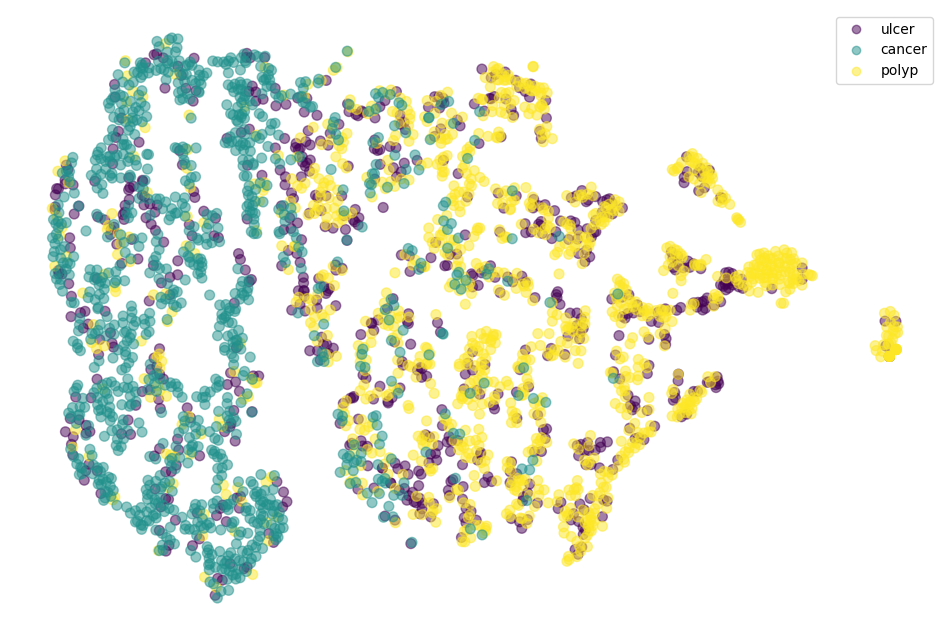

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.axis('off')
scatter = plt.scatter(plot_x, plot_y, marker = 'o',s = 50, c=data_y.tolist(), alpha= 0.5,cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=['ulcer','cancer','polyp'])

**Helper Function**

In [18]:
def draw_bbox(image, box, label, label_id, color):
    alpha = 0.1 # box inner color
    alpha_box = 0.7 # Text Box color
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(str(label_id) + ' ' + label.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
    #cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]), color, -1) # Xmin, Ymin, Xmax, Ymax # 내부까지 color
    #cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output) # 맨뒤의 output는 덮어쓰기 반환
    cv2.rectangle(overlay_text, (box[0], box[1]-text_height-5),
                  (box[0]+text_width, box[1]), color, -1) # 검은색 상자 형성 
    cv2.addWeighted(overlay_text, alpha_box, output, 1-alpha_box, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]), color, thickness)
    cv2.putText(output, str(label_id) + ' ' + label.upper(), (box[0], box[1]-3),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    
    return output

In [19]:
class_ids, class_names = list(zip(*set(zip(tmp.lesion_label, tmp.lesion))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['ulcer', 'polyp', 'cancer']

#### Ulcer Visualization

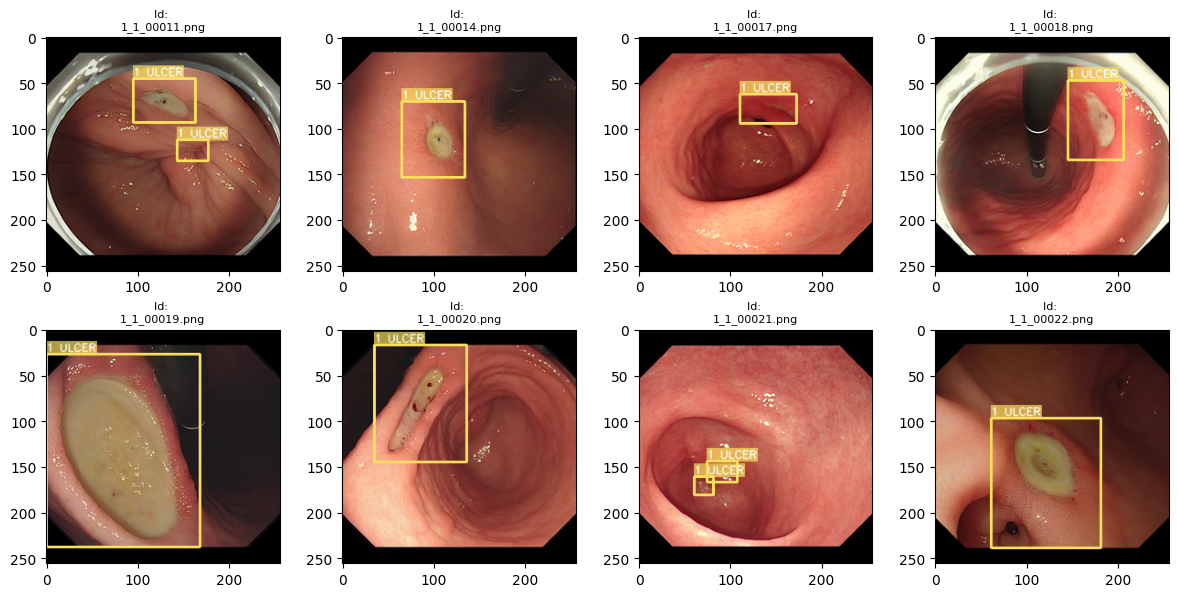

In [20]:
label2color = [[random.randint(0,255) for i in range(3)] for _ in classes ]
thickness = 2

plt.figure(figsize=(12,6))

tmp2 = tmp[tmp['lesion'] == 'ulcer']
image_id = tmp2.image_id.unique()

for i in range(8):
    records = tmp[tmp['image_id'] == image_id[i]]
    
    path = records.iloc[0]['image_path']
    img = Image.open(path)
    img = np.array(img)

    boxes = records[['x_min','y_min','x_max','y_max']].values
    labels = records['lesion_label'].tolist()
    
    plt.subplot(2,4,i+1)
    plt.title(f'Id: \n{image_id[i]}', size=8)
    
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id - 1]
        img = draw_bbox(img, list(np.int_(box)), classes[label_id - 1], label_id, color)
    plt.imshow(img)
    # plt.axis('off')
    
    
plt.tight_layout()
plt.show()

#### Polyp Visualization

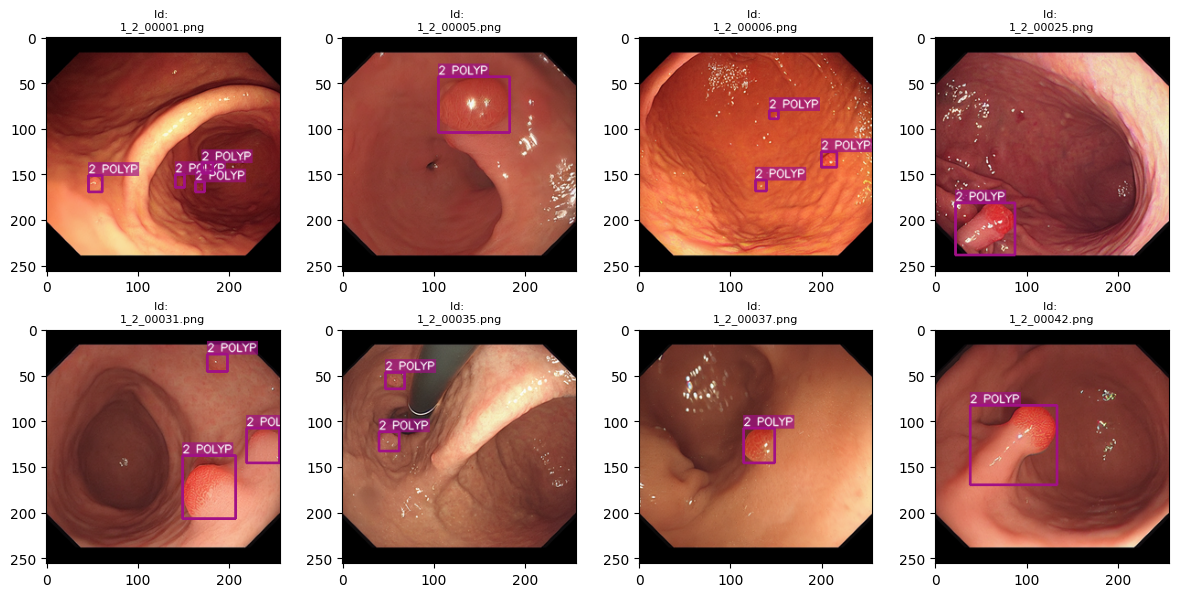

In [21]:
plt.figure(figsize=(12,6))

tmp2 = tmp[tmp['lesion'] == 'polyp']
image_id = tmp2.image_id.unique()

for i in range(8):
    records = tmp[tmp['image_id'] == image_id[i]]
    
    path = records.iloc[0]['image_path']
    img = Image.open(path)
    img = np.array(img)

    boxes = records[['x_min','y_min','x_max','y_max']].values
    labels = records['lesion_label'].tolist()
    
    plt.subplot(2,4,i+1)
    plt.title(f'Id: \n{image_id[i]}', size=8)
    
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id - 1]
        img = draw_bbox(img, list(np.int_(box)), classes[label_id - 1], label_id, color)
    plt.imshow(img)
    # plt.axis('off')
    
    
plt.tight_layout()
plt.show()

#### Cancer Visualization

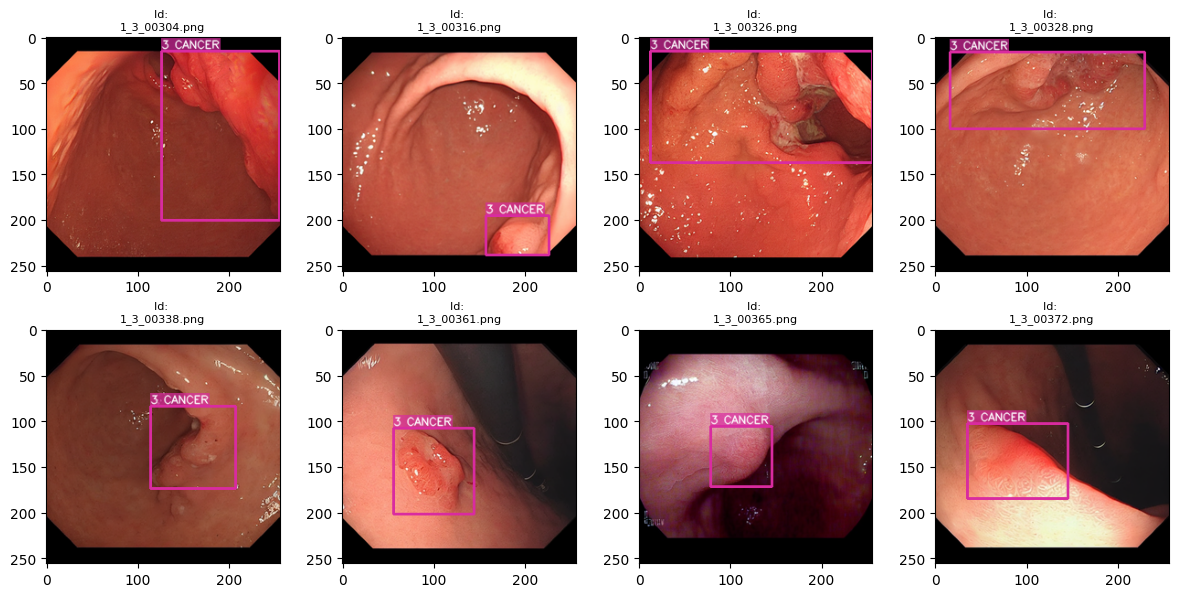

In [22]:
plt.figure(figsize=(12,6))

tmp2 = tmp[tmp['lesion'] == 'cancer']
image_id = tmp2.image_id.unique()

for i in range(8):
    records = tmp[tmp['image_id'] == image_id[i]]
    
    path = records.iloc[0]['image_path']
    img = Image.open(path)
    img = np.array(img)

    boxes = records[['x_min','y_min','x_max','y_max']].values
    labels = records['lesion_label'].tolist()
    
    plt.subplot(2,4,i+1)
    plt.title(f'Id: \n{image_id[i]}', size=8)
    
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id - 1]
        img = draw_bbox(img, list(np.int_(box)), classes[label_id - 1], label_id, color)
    plt.imshow(img)
    # plt.axis('off')
    
    
plt.tight_layout()
plt.show()